Задача "Модератор Одноклассников"

Формулировка задания

В социальной сети Одноклассники есть платформа для разметки данных. На ней пользователям была дана задача выделить прямоугольником заданный объект на фотографии. По ответам людей нужно восстановить истинное положение объекта.

На входе вы получите краудсорсинговую разметку и данные в виде любимых всеми табличек, бейзлайн и тестовый сабмит с нулями. 

В ответ вы должны будете прислать просто файл (такой же, как и sample_submit) с вашими предсказаниями.

Предварительные результаты валидируются на 50% выборки. В день можно загружать не более 5 решений.

Для оценки решения будет использоваться метрика mIOU (mean intersection over union). Если еще не сталкивались с данной метрикой, то рекомендуем прочитать о ней [статью](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/).

https://mlbootcamp.ru/round/21/tasks/

In [4]:
import os
import json
from tqdm import tqdm_notebook
import itertools
import time
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [6]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
matplotlib.rcParams['axes.facecolor']='white'
matplotlib.rcParams['axes.edgecolor']='black'
matplotlib.rcParams['xtick.color']='black'
matplotlib.rcParams['ytick.color']='black'
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['black', "red", "blue", "limegreen", 'purple', 'yellow', 'orange', 'green'])
matplotlib.rcParams['axes.linewidth']=1.3
matplotlib.rcParams['text.color']='black'
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

Прописываем путь до папки с данными

In [7]:
FILE_PATH = '/Users/anton.andreytsev/competitions/data/moderator_odnoklassnikov_data'

Загружаем данные

In [19]:
X_train = pd.read_csv(os.path.join(FILE_PATH, 'train_data.csv'))
y_train = pd.read_csv(os.path.join(FILE_PATH, 'train_answers.csv'))
X_test = pd.read_csv(os.path.join(FILE_PATH, 'test_data.csv'))
submit = pd.read_csv(os.path.join(FILE_PATH, 'sample_submit_zero.csv'), header=None)

In [11]:
X_train.head()

,userId,itemId,Xmin,Ymin,Xmax,Ymax
0,1164,6132,62,656,276,803
1,1399,6132,184,662,235,740
2,1694,6132,63,648,272,830
3,916,6132,111,637,253,831
4,1621,6132,60,651,242,819


In [36]:
X_test.head()

,userId,itemId,Xmin,Ymin,Xmax,Ymax
0,1581,34804,86,640,242,743
1,1351,34804,85,655,273,766
2,161,34804,85,648,268,748
3,313,5704,32,618,647,1268
4,1097,5704,25,620,602,1242


Объединим треин и тест в один датафрейм

In [146]:
dat = pd.concat([pd.merge(X_train, y_train, on='itemId'), X_test], sort=False)
tr_indexes = np.arange(X_train.shape[0])
te_indexes = np.arange(X_test.shape[0]) + X_train.shape[0]
dat.index = range(dat.shape[0])

Убедимся, что в треине нет пропусков

In [154]:
dat.loc[tr_indexes].isnull().sum()

userId       0
itemId       0
Xmin         0
Ymin         0
Xmax         0
Ymax         0
Xmin_true    0
Ymin_true    0
Xmax_true    0
Ymax_true    0
dtype: int64

В тесте как и ожидается пропуски только в таргете

In [156]:
dat.loc[te_indexes].isnull().sum()

userId          0
itemId          0
Xmin            0
Ymin            0
Xmax            0
Ymax            0
Xmin_true    3615
Ymin_true    3615
Xmax_true    3615
Ymax_true    3615
dtype: int64

---
### EDA
---

Построим матрицу, описывающую сколько юзеров разметило сколько картинок

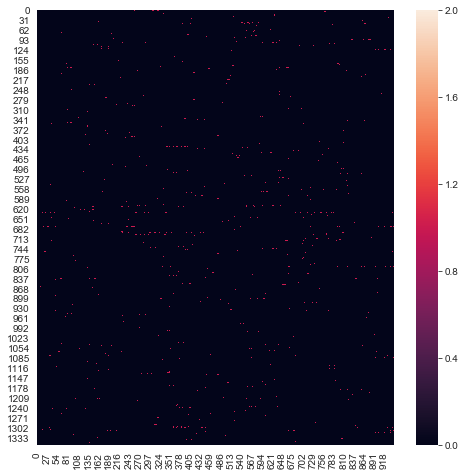

In [172]:
sns.heatmap(pd.crosstab(dat.userId[tr_indexes], dat.itemId[tr_indexes]).values);